## Export mmdetection models to CoreML format

This notebook will try to convert models from the [mmdetection](https://github.com/open-mmlab/mmdetection) library to CoreML format. This script tries to solve a bunch of dependencies problems that I founded when trying to convert these models.


In [1]:
# firsts thing first, install the requirements.
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# import libraries
import os
import random

import cv2
import numpy as np
import ipyplot

import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import utils

We need to build libtorch, install mmdetection and mmdeploy according to the following docs:

https://mmdeploy.readthedocs.io/en/latest/01-how-to-build/macos-arm64.html

https://mmdeploy.readthedocs.io/en/latest/05-supported-backends/coreml.html

### 1. Build libtorch, the slow part.

In [3]:
PYTORCH_VERSION = "2.0.0"
PYTORCH_DIR= "third_party/pytorch"

Clone PyTorch version (~8min)

In [4]:
if not os.path.exists(PYTORCH_DIR):
    !git clone --recursive --depth 1 --branch v{PYTORCH_VERSION} https://github.com/pytorch/pytorch {PYTORCH_DIR}

Build libtorch from source (~16min)

In [5]:
Torch_DIR=os.getcwd()+"/third_party/pytorch/build/install/share/cmake/Torch"
if not os.path.exists(Torch_DIR):
    !cd {PYTORCH_DIR} && \
    mkdir -p build && cd build && \
    cmake .. \
        -DCMAKE_BUILD_TYPE=Release \
        -DPYTHON_EXECUTABLE=`which python` \
        -DCMAKE_INSTALL_PREFIX=install \
        -DDISABLE_SVE=ON

    !cd {PYTORCH_DIR}/build/ && make -j4 && make install

### 2. Build mmdeploy

We will need to build mmdeploy as well, more or less following what is described in the lib [docs](https://mmdeploy.readthedocs.io/en/latest/01-how-to-build/macos-arm64.html).

In [6]:
MMDEPLOY_DIR = "third_party/mmdeploy/"
COMMIT_HASH = "bc75c9d6c8940aa03d0e1e5b5962bd930478ba77"
!git -C {MMDEPLOY_DIR} pull || git clone --recursive https://github.com/open-mmlab/mmdeploy.git {MMDEPLOY_DIR}
!cd {MMDEPLOY_DIR} && git reset --hard {COMMIT_HASH}

Already up to date.
HEAD is now at bc75c9d6 bump version to v1.13.1 (#2613)


First thing is that there is an error in the CMakeLists.txt that set the standard to C++14 instead of C++17. [See issue](https://github.com/open-mmlab/mmdeploy/issues/2638) for more details.

In [7]:
with open(f"{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists.txt", "r") as f, \
        open(f"{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists_fixed.txt", "w") as f_out:
    content = f.readlines()
    for ln in content:
        if "set(CMAKE_CXX_STANDARD 14)" in ln:
            ln = "    set(CMAKE_CXX_STANDARD 17)\n"
        f_out.write(ln)

os.rename(f'{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists_fixed.txt', f'{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists.txt')
print("CMakeLists.txt updated")

CMakeLists.txt updated


In [8]:
Torch_DIR=os.getcwd()+"/third_party/pytorch/build/install/share/cmake/Torch"

print("will compile mmdeploy using torch from ", Torch_DIR)
!cd {MMDEPLOY_DIR} && \
    mkdir -p build && cd build && \
    cmake -DMMDEPLOY_TARGET_BACKENDS=coreml -DTorch_DIR={Torch_DIR} .. && \
    make -j4 && make install

will compile mmdeploy using torch from  /Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/third_party/pytorch/build/install/share/cmake/Torch
CMake Error: The current CMakeCache.txt directory /Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/third_party/mmdeploy/build/CMakeCache.txt is different than the directory /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy/build where CMakeCache.txt was created. This may result in binaries being created in the wrong place. If you are not sure, reedit the CMakeCache.txt
CMake Error: The source "/Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/third_party/mmdeploy/CMakeLists.txt" does not match the source "/Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy/CMakeLists.txt" used to generate cache.  Re-run cmake with

In [9]:
!cd {MMDEPLOY_DIR} && pip install -v -e .

Using pip 24.0 from /Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/pip (python 3.10)
Obtaining file:///Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/third_party/mmdeploy
  Preparing metadata (setup.py) ...   Running command python setup.py egg_info
  /Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/setuptools/installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
    warnings.warn(
  running egg_info
  creating /private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-nkq91xtm/mmdeploy.egg-info
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-nkq91xtm/mmdeploy.egg-info/SOURCES.txt'
  /Users/gustavofuhr/pr

### 3. Install mmdetection from source

In [10]:
MMDETECTION_DIR = "third_party/mmdetection/"
COMMIT_HASH = "cfd5d3a985b0249de009b67d04f37263e11cdf3"
!git -C {MMDETECTION_DIR} pull || git clone --recursive https://github.com/open-mmlab/mmdetection.git {MMDETECTION_DIR}
!cd {MMDETECTION_DIR} && git reset --hard {COMMIT_HASH}

Already up to date.
HEAD is now at cfd5d3a9 Release MM-GroundingDINO SwinB and SwinL Weights (#11460)


In [11]:
!mim install mmengine
!mim install "mmcv >=2.0.0rc4, < 2.1.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch2.0.0/index.html

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch2.0.0/index.html

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [17]:
%pip install -v -e {MMDETECTION_DIR}/

Using pip 24.0 from /Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/pip (python 3.10)
Obtaining file:///Users/gustavofuhr/projects/object_detection_ios_comprehensive/rtmdet_mmdetection_to_coreml/third_party/mmdetection
  Preparing metadata (setup.py) ...   Running command python setup.py egg_info
  running egg_info
  creating /private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-edlwmddt/mmdet.egg-info
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-edlwmddt/mmdet.egg-info/SOURCES.txt'
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-edlwmddt/mmdet.egg-info/SOURCES.txt'
done
  Attempting uninstall: mmdet
    Found existing installation: mmdet 3.3.0
    Uninstalling mmdet-3.3.0:
      Removing file or directory /Users/gustavofuhr/projects/object_detection_ios_comprehensive/

Create a mmdetection model for comparison

In [18]:
from mmdet.apis import init_detector, inference_detector

# Specify the path to model config and checkpoint file
config_file = 'third_party/mmdetection/configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py'
checkpoint_file = 'rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'
mm_model = init_detector(config_file, checkpoint_file, device='cpu')
mmdetection_model = lambda image_file: inference_detector(mm_model, image_file)

Loads checkpoint by local backend from path: rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



#### 4. Finally, convert the detector model!

Download the models

In [19]:
#if not os.path.exists("retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth"):
#    !wget https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r18_fpn_1x_coco/retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth .
if not os.path.exists("rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth"):
    !wget https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth .

Now will conver the model do CoreML, hopefully. I got an error when running the conversion script in a notebook, because it tried to open matplotlib to show some errors. That's why there is `MPLBACKEND="template"` there.

In [26]:
!cd third_party/ && MPLBACKEND="template" && python mmdeploy/tools/deploy.py \
    mmdeploy/configs/mmdet/_base_/base_coreml_static-640x640.py \
    mmdetection/configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py \
    ../rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth \
    mmdetection/demo/demo.jpg \
    --work-dir ../work_dir/rtmdet2 \
    --device cpu \
    --dump-info

07/20 11:45:20 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "Codebases" registry tree. As a workaround, the current "Codebases" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
07/20 11:45:20 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "mmdet_tasks" registry tree. As a workaround, the current "mmdet_tasks" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
07/20 11:45:21 - mmengine - INFO - Start pipeline mmdeploy.apis.pytorch2torchscript.torch2torchscript in subprocess
07/20 11:45:21 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "Codebases" registry tree. As a workaround, the current "Codebas

If everything worked out, you should have a .mlpackage with the CoreML converted model (including NMS). It's a good idea to open it in Xcode to check some metadata.

In [ ]:
#!du -sh retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth
#!du -sh work_dir/retinanet/end2end.mlpackage/

!du -sh rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
!du -sh work_dir/rtmdet/end2end.mlpackage/

 55M	rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
 21M	work_dir/rtmdet/end2end.mlpackage/


The conversion script creates a lot of files in the `work_dir` directory. MMdeploy make inferences in both models so that we can check if that worked:

In [ ]:
images = ["work_dir/rtmdet/output_pytorch.jpg", "work_dir/rtmdet/output_coreml.jpg"]
labels = ["PyTorch", "CoreML"]
ipyplot.plot_images(images, labels, img_width=400)

### 5. CoreML inference

Now let's run inference using the coremltools backend. This basically means that we will not use mmdetection to pre-process the images and we'll need to figure out what is the output.

Pre-processing images comes from these files:
- `mmdetection/configs/_base_/datasets/coco_detection.py`
- `mmdetection/configs/rtmdet/rtmdet_l_8xb32-300e_coco.py`

The config "pipelines" as the mmdetection 

In [ ]:
IMAGE_TARGET_SIZE = (640, 640)

In [ ]:
def preprocess_image(image):
    """
    Basically convert the image to a tensor (channel first) and normalize it. 
    IMPORTANT: it does not resize the image.
    """
    im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im = im.astype(np.float32)
    # im /= 255 no need, since mean and std are with respect to 255

    # mean and std values taken from rtmdet_l_8xb32-300e_coco.py file
    mean=[103.53, 116.28, 123.675],
    std=[57.375, 57.12, 58.395],

    im -= mean
    im /= std

    im = im.transpose(2, 0, 1) # HWC -> CHW
    im = np.expand_dims(im, 0)  # Add batch dimension.

    return im

The output of the CoreML model (for RTMDet) will be a dictionary with two items:
- dets: this is a tensor of size 1x200x5 that represent 200 boxes that would be predicted by the model. Each box comes with four coordinates and a score (which we should apply a threshold); the boxes are returned in decreasing order of score, which is cool!
- labels: this is a an array of 200 integers given class numbers (coco) for each box

In [ ]:

from mmdet.datasets.coco import CocoDataset
coco_classes = CocoDataset.METAINFO["classes"]

def postprocess_output(output, threshold = 0.5):
    boxes = output["dets"][0,:,:]
    id_good_boxes = np.where(boxes[:,4] > threshold)  # boxes above threshold
    
    good_boxes = boxes[id_good_boxes, :][0]
    good_labels = output["labels"][0, id_good_boxes][0]

    detections = []
    for box, label in zip(good_boxes, good_labels):
        detections.append({"label": coco_classes[label], "box": box[:4].tolist(), "score": box[4]})

    return detections

Quick function to plot object detection


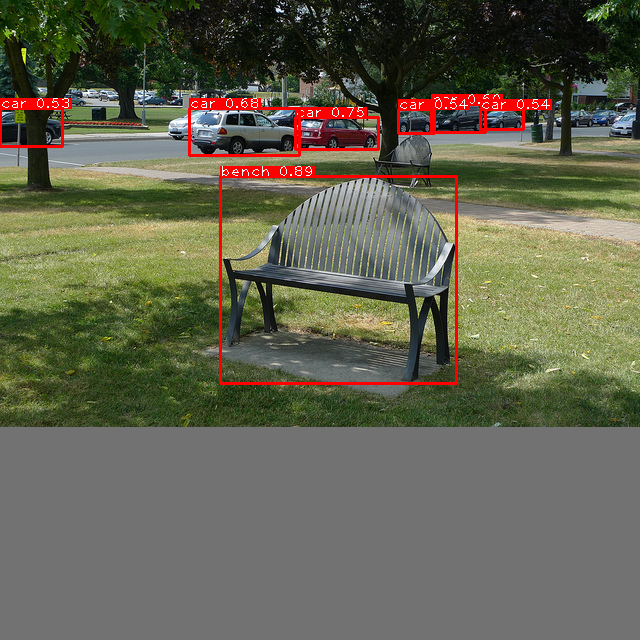


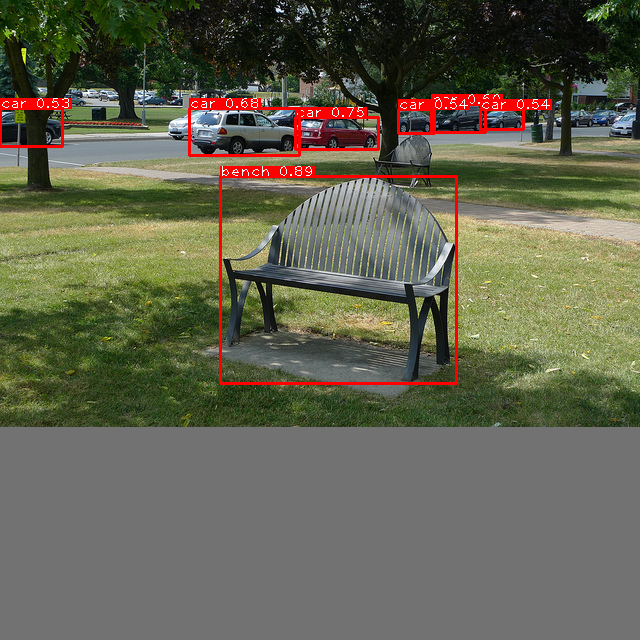

In [ ]:
import coremltools as ct
from utils import plot_detections

model = ct.models.MLModel("work_dir/rtmdet/end2end.mlpackage", compute_units=ct.ComputeUnit.ALL)

image = cv2.imread("third_party/mmdetection/demo/demo.jpg")
image = utils.resize_keep_ratio(image, IMAGE_TARGET_SIZE, padding=True)

pred = model.predict({"input": preprocess_image(image)})

im = plot_detections(image, postprocess_output(pred))
ipyplot.plot_images([im], img_width=800)

### Compression of models

We'll try to apply quantization on the converted models and see results in some sample images of before and after.

In [ ]:
from coremltools.models.neural_network import quantization_utils
import coremltools as ct

compressed_model = ct.compression_utils.palettize_weights(model, mode="kmeans", nbits=8)
compressed_model.save('work_dir/rtmdet/compressed_model_8bits.mlpackage')


/Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/coremltools/models/neural_network/quantization_utils.py:390: ConvergenceWarning: Number of distinct clusters (80) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  ).fit(wf)
/Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/coremltools/models/neural_network/quantization_utils.py:390: ConvergenceWarning: Number of distinct clusters (80) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  ).fit(wf)
/Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/coremltools/models/neural_network/quantization_utils.py:390: ConvergenceWarning: Number of distinct clusters (80) found smaller than n_clusters (256). Possibly due to duplicate points i

In [ ]:
!du -sh work_dir/rtmdet/compressed_model_8bits.mlpackage

5.6M	work_dir/rtmdet/compressed_model_8bits.mlpackage


Now take random images inside `sample_images` to check for difference between the original, converted and compressed models.

Comparing models for ../sample_images/2008_000013.jpg
(640, 640, 3) (640, 640, 3) (640, 640, 3)



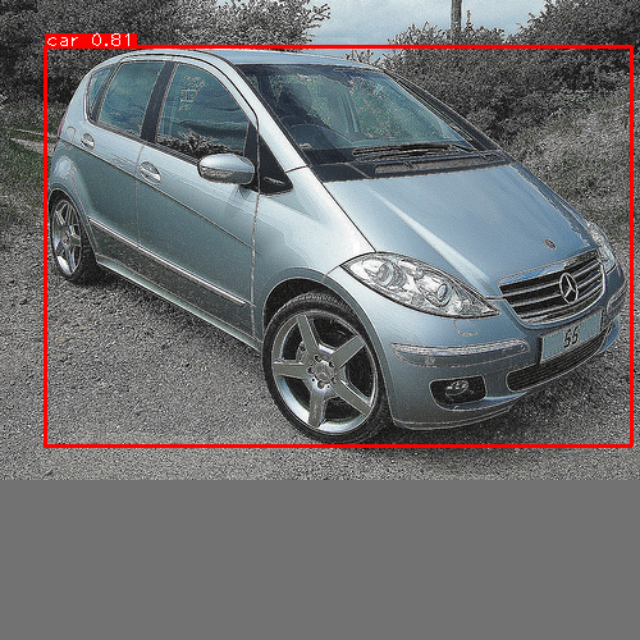
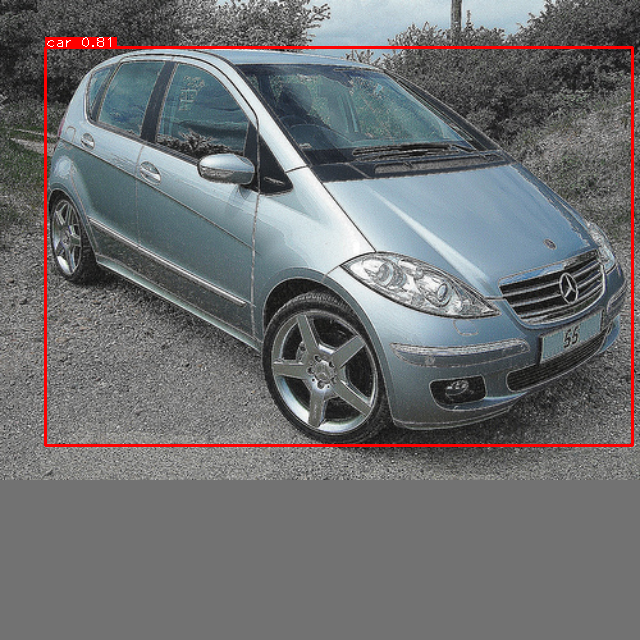
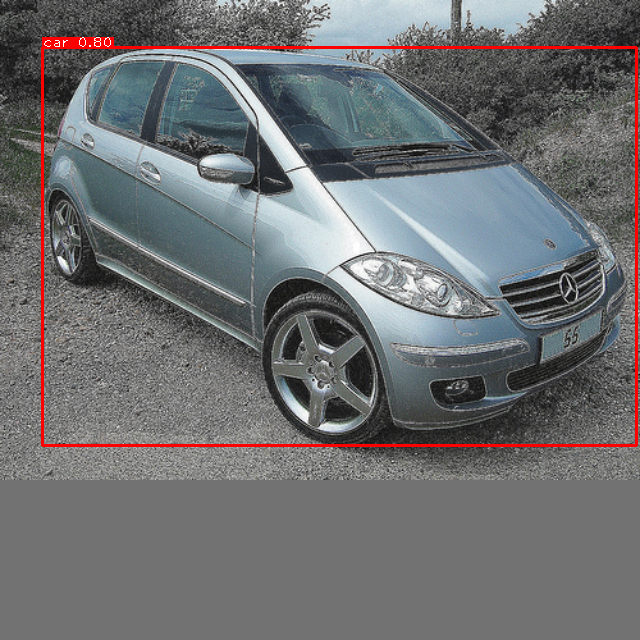


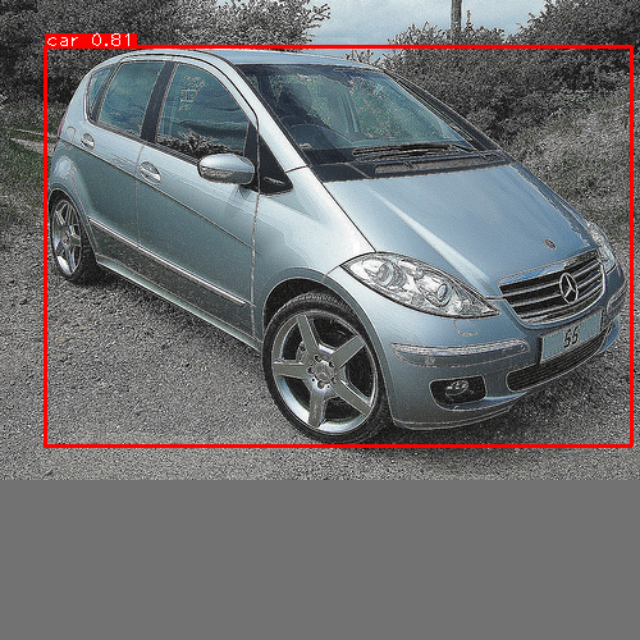
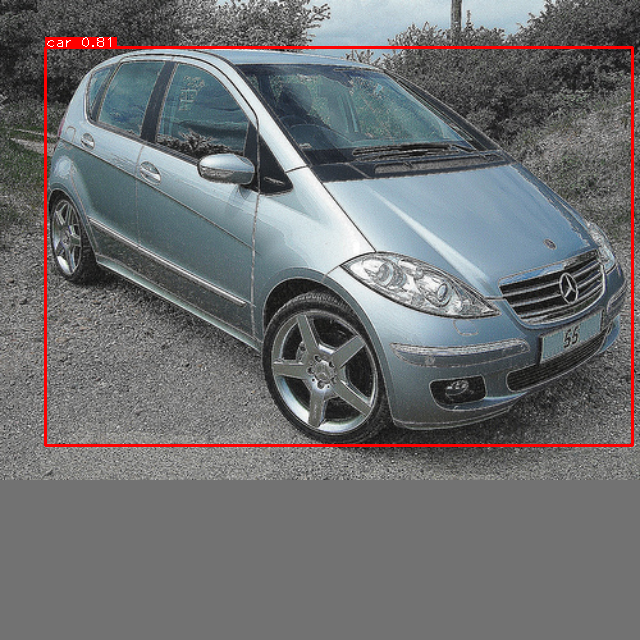
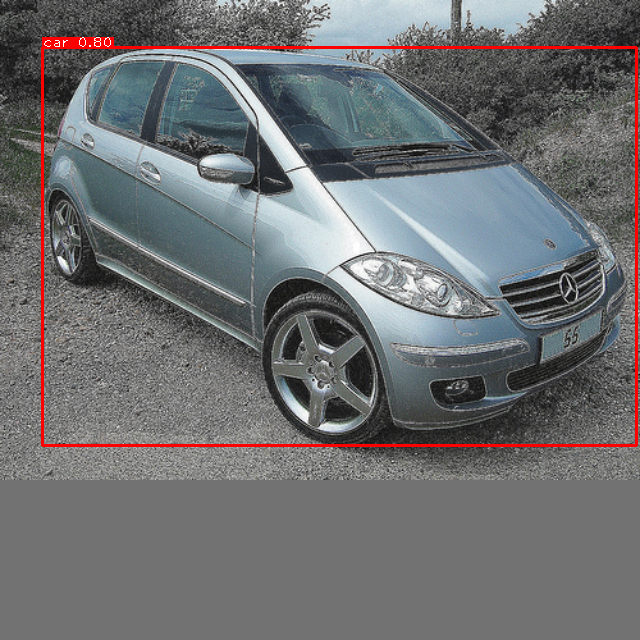

In [ ]:
from mmdet_postprocess import postprocess_mmdetection_output

image_files = [os.path.join("../sample_images/",f) for f in os.listdir("../sample_images/") \
                                if f.endswith(".jpg") or f.endswith(".jpeg") or f.endswith(".png")]
r_image_file = random.choice(image_files)
print(f"Comparing models for {r_image_file}")

# get inference from mmdetection
pred_mmdetection = mmdetection_model(r_image_file)


im_pred_mmdetection = plot_detections(cv2.imread(r_image_file), postprocess_mmdetection_output(pred_mmdetection, 0.5))
# im resizing here because despite mmdetection resizing the image as we do, the output boxes are not scaled 
# back to the original image size
im_pred_mmdetection = utils.resize_keep_ratio(im_pred_mmdetection, (640,640), padding=True)

im_to_det = utils.resize_keep_ratio(cv2.imread(r_image_file), (640, 640), padding=True)
pred_converted = model.predict({"input": preprocess_image(im_to_det)})
pred_compressed = compressed_model.predict({"input": preprocess_image(im_to_det)})

im_pred_converted = plot_detections(im_to_det, postprocess_output(pred_converted, 0.5), detector_size=(640, 640))
im_pred_compressed = plot_detections(im_to_det, postprocess_output(pred_compressed, 0.5), detector_size=(640, 640))
ipyplot.plot_images([im_pred_mmdetection, im_pred_converted, im_pred_compressed], img_width=300, labels=["mmdetection", "converted", "compressed"])
